# This notebook will clean and explore the dataset to then start creating models off of it, to the chosen problems.

#### Loading in the dataset and initial exploration

In [3]:
#if using kaggle api 

#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("piterfm/massive-missile-attacks-on-ukraine")

#print("Path to dataset files:", path)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme (style="darkgrid")

In [3]:
# from direct download

df = pd.read_csv("Datasets/missile_attacks_daily.csv")

dataset = df

In [4]:
dataset.head()

,time_start,time_end,model,launch_place,target,carrier,launched,destroyed,not_reach_goal,cross_border_belarus,back_russia,still_attacking,num_hit_location,num_fall_fragment_location,affected region,destroyed_details,launched_details,launch_place_details,source
0,2025-06-14 20:00,2025-06-15 09:00,Shahed-136/131,Primorsko-Akhtarsk and Kursk oblast and Bryans...,Ukraine,NaN,183.0,111.0,48.0,NaN,NaN,NaN,1.0,6.0,['Poltava oblast'],"{'south': 3, 'east': NaN}",NaN,NaN,kpszsu/posts/pfbid0YNupaR6nrerWbo2zKGkDhdwxYVP...
1,2025-06-15 02:10,2025-06-15 03:45,Kalibr,Black Sea,Poltava oblast,Navi,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kpszsu/posts/pfbid0YNupaR6nrerWbo2zKGkDhdwxYVP...
2,2025-06-15 02:10,2025-06-15 03:45,Iskander-M/KN-23,Kursk oblast,Poltava oblast,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kpszsu/posts/pfbid0YNupaR6nrerWbo2zKGkDhdwxYVP...
3,2025-06-15 02:10,2025-06-15 03:45,Iskander-K,Rostov oblast,Poltava oblast,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kpszsu/posts/pfbid0YNupaR6nrerWbo2zKGkDhdwxYVP...
4,2025-06-15 02:10,2025-06-15 02:25,X-47 Kinzhal,Astrakhan oblast,Poltava oblast,MiG-31K,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kpszsu/posts/pfbid0YNupaR6nrerWbo2zKGkDhdwxYVP...


In [5]:
len(df)

2556

In [6]:
# Viewing the datatypes of the dataset for cleaning
df.dtypes


time_start                     object
time_end                       object
model                          object
launch_place                   object
target                         object
carrier                        object
launched                      float64
destroyed                     float64
not_reach_goal                float64
cross_border_belarus          float64
back_russia                   float64
still_attacking               float64
num_hit_location              float64
num_fall_fragment_location    float64
affected region                object
destroyed_details              object
launched_details               object
launch_place_details           object
source                         object
dtype: object

# Cleaning the dataset

#### Convert time_start and time_end to datetime
along with processing null times into a default value of 6am to maintain data

In [7]:
# Back up original strings
df['raw_time_start'] = df['time_start']
df['raw_time_end'] = df['time_end']

# Convert to datetime, but don't coerce to maintain usable data by handling it later
df['time_start'] = pd.to_datetime(df['time_start'], errors='ignore')
df['time_end'] = pd.to_datetime(df['time_end'], errors='ignore')

# Function to parse with default time
def parse_with_default_time(original_str):
    try:
        parsed = pd.to_datetime(original_str)
        if isinstance(parsed, pd.Timestamp):
            # Add 6am if no time part was included (defaults to midnight)
            if parsed.time() == pd.Timestamp(0).time() and ':' not in original_str:
                return parsed.replace(hour=6)
            return parsed
        else:
            return pd.NaT
    except Exception:
        return pd.NaT

# Apply to columns
df['time_start'] = df['raw_time_start'].apply(parse_with_default_time)
df['time_end'] = df['raw_time_end'].apply(parse_with_default_time)

# Drop backups
df.drop(columns=['raw_time_start', 'raw_time_end'], inplace=True)


C:\Users\sonny bell\AppData\Local\Temp\ipykernel_30820\3801261995.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['time_start'] = pd.to_datetime(df['time_start'], errors='ignore')
C:\Users\sonny bell\AppData\Local\Temp\ipykernel_30820\3801261995.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['time_end'] = pd.to_datetime(df['time_end'], errors='ignore')


In [8]:
# Verifying the changes
print(df[['time_start', 'time_end']].head())
print(df.dtypes) # time_start and time_end should now be datetime64[ns]

           time_start            time_end
0 2025-06-14 20:00:00 2025-06-15 09:00:00
1 2025-06-15 02:10:00 2025-06-15 03:45:00
2 2025-06-15 02:10:00 2025-06-15 03:45:00
3 2025-06-15 02:10:00 2025-06-15 03:45:00
4 2025-06-15 02:10:00 2025-06-15 02:25:00
time_start                    datetime64[ns]
time_end                      datetime64[ns]
model                                 object
launch_place                          object
target                                object
carrier                               object
launched                             float64
destroyed                            float64
not_reach_goal                       float64
cross_border_belarus                 float64
back_russia                          float64
still_attacking                      float64
num_hit_location                     float64
num_fall_fragment_location           float64
affected region                       object
destroyed_details                     object
launched_details            

# Data verification

#### Checking for completeness

In [9]:
# List of important columns to check for completeness
key_columns = ['still_attacking', 'not_reach_goal', 'time_start', 'time_end','affected region', 'target' ]

# Total rows
total_rows = len(df)

# Count complete rows (no NaN or NaT in key columns)
complete_rows = df[key_columns].dropna().shape[0]
usable_pct = (complete_rows / total_rows) * 100

print(f"Usable rows (no NaNs in {key_columns}): {complete_rows} / {total_rows} ({usable_pct:.2f}%)")

for col in key_columns:
    missing = df[col].isna().sum()
    percent = (missing / total_rows) * 100
    print(f"{col}: {missing} missing ({percent:.2f}%)")


Usable rows (no NaNs in ['still_attacking', 'not_reach_goal', 'time_start', 'time_end', 'affected region', 'target']): 5 / 2556 (0.20%)
still_attacking: 2521 missing (98.63%)
not_reach_goal: 2250 missing (88.03%)
time_start: 0 missing (0.00%)
time_end: 0 missing (0.00%)
affected region: 2426 missing (94.91%)
target: 29 missing (1.13%)


## *From this testing I have decided to remove still_attacking, affected region, and not reach goal from the models due to limited usable data*

#### Affected region 

As the amount of usable data is highly limited for this column leading to my initial plan changing from trying to solve the problem of most attacked region to most targeted region as this contains vastly more data that is usable 

##### because of the amount of generic values in the target column consideration for how these should be dealt with is critical

In [10]:
# Calculating the amount of unique targets and Calculating the total rows in affected target column
unique_count = df['target'].nunique()
print(len(df['target']),'total rows in the target column.',f"{unique_count} of them are unique values.")

count = df['target'].str.lower().str.count('ukraine').sum()
print('of the',(len(df['target'])),'total rows',f"{count} are generic Ukraine values")


2556 total rows in the target column. 98 of them are unique values.
of the 2556 total rows 962.0 are generic Ukraine values


In [11]:
# calculating the amount of nat (Not a Time) values in the two columns
total_rows = len(df)

# For affected region
nat_start_count = df['target'].isna().sum()
nat_start_pct = (nat_start_count / total_rows) * 100


print(f"targets: {nat_start_count} NaT values ({nat_start_pct:.2f}%)")

targets: 29 NaT values (1.13%)


##### Bar chart showing the target regions

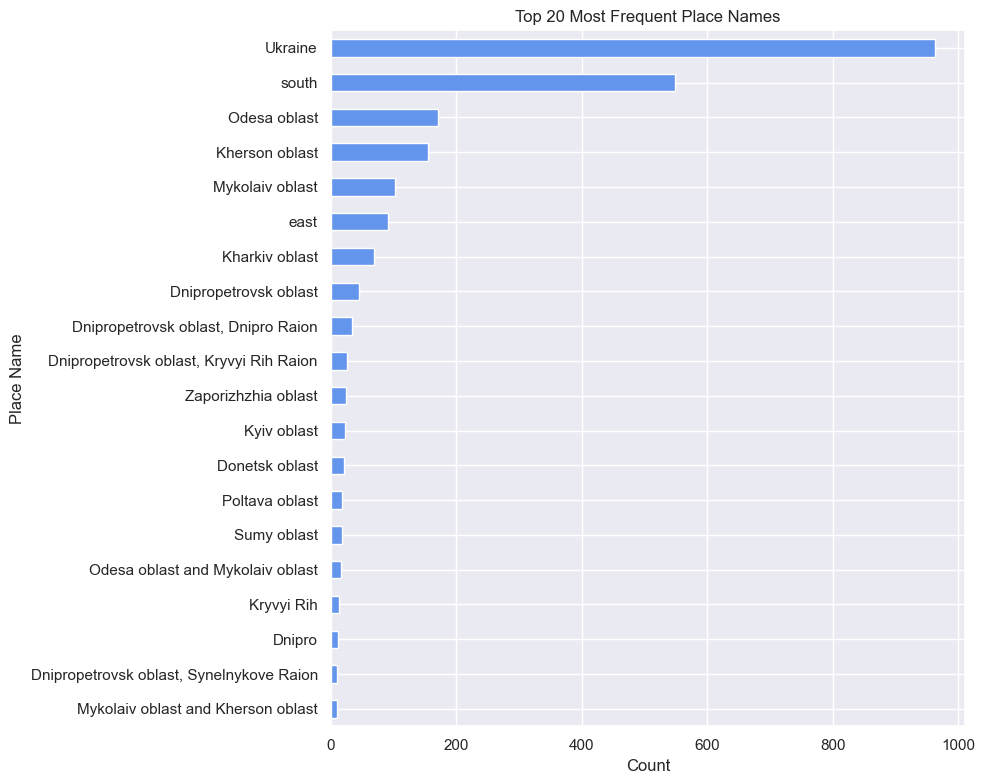

In [12]:
top_places = df['target'].value_counts().head(20)
top_places.plot(kind='barh', figsize=(10, 8), color='cornflowerblue')

plt.xlabel('Count')
plt.ylabel('Place Name')
plt.title('Top 20 Most Frequent Place Names')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()


from the skewed data of target with the default if unknown being just Ukraine this value must be removed to create an accurate model.

In [13]:
# Drop rows where 'target' is NaN (but keep all other columns)
df = df.dropna(subset=['target'])

# Remove rows where 'target' contains 'ukraine' (case-insensitive)
df = df[~df['target'].str.contains('ukraine', case=False, na=False)]


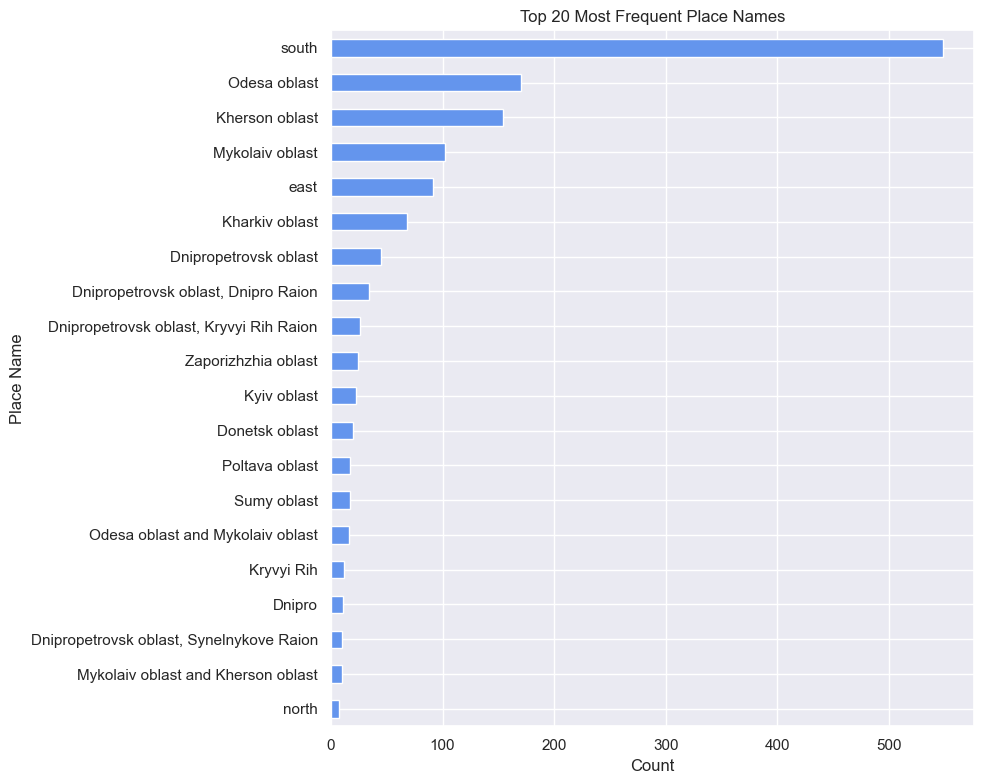

In [14]:
top_places = df['target'].value_counts().head(20)
top_places.plot(kind='barh', figsize=(10, 8), color='cornflowerblue')

plt.xlabel('Count')
plt.ylabel('Place Name')
plt.title('Top 20 Most Frequent Place Names')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()


using a bar chart to visualize how much of the data is generic vs specific for K-means.

In [15]:
# Filter out generic-only labels for clustering
generic_labels = ['south', 'east', 'north', 'west', 'central']
df_kmeans = df[~df['target'].str.lower().isin(generic_labels)]


The bart chart makes it clear that without the generic data enough specific usable data remains for K-means.

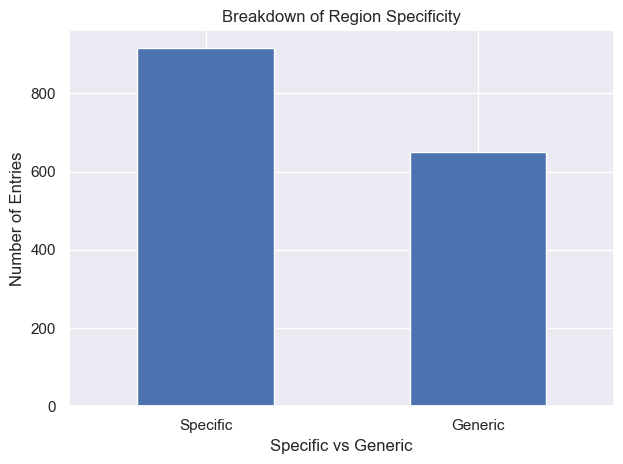

In [16]:
df['Specific vs Generic'] = df['target'].str.lower().isin(generic_labels)
df['Specific vs Generic'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['Specific', 'Generic'], rotation=0)
plt.title('Breakdown of Region Specificity')
plt.ylabel('Number of Entries')
plt.tight_layout()
plt.show()


Creating a new column called targe_generic to store the generic target data in.

In [17]:
# List of generic directional terms
generic_keywords = ['south', 'east', 'north', 'west', 'central']

# Create a regex pattern to match any of them (case-insensitive)
import re
pattern = '|'.join(generic_keywords)

# Move partial matches to target_generic
df['target_generic'] = df['target'].where(df['target'].str.contains(pattern, case=False, na=False))

# Keep only specific values in 'target'
df['target'] = df['target'].where(~df['target'].str.contains(pattern, case=False, na=False))


once again comparing the target regions

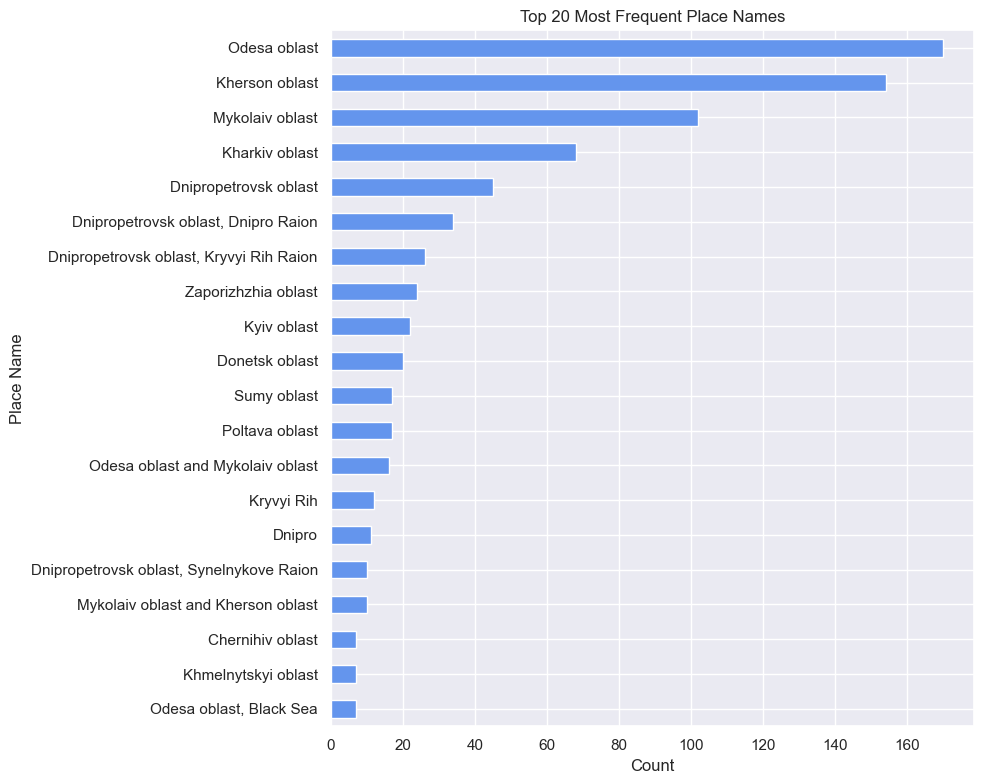

In [18]:
top_places = df['target'].value_counts().head(20)
top_places.plot(kind='barh', figsize=(10, 8), color='cornflowerblue')

plt.xlabel('Count')
plt.ylabel('Place Name')
plt.title('Top 20 Most Frequent Place Names')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()


# Exploring the dataset

This graph shows Missile launched and UAVs vs Destroyed
Overall trend:

    There's a dramatic increase in missile/UAV activity starting around mid/late 2024.

    This shows a clear escalation in attacks.

2. Intercept effectiveness:

    The destroyed line follows the launched line fairly closely, but:

        In earlier periods, they're often very close — indicating high interception rates.

        In the more recent months (late 2024–early 2025), the gap between launched and destroyed widens, suggesting:

            Either more missiles are getting through.

            Or defenses are being overwhelmed.

            Or simply more launched than before — harder to keep up.

3. Attack waves:

    You can spot waves or cycles of intensity — peaks every few weeks.

    Could be tied to strategic events, weather conditions, or specific campaigns.

In [19]:
df_weekly = df.set_index('time_start').resample('W')[['launched', 'destroyed']].sum().fillna(0)

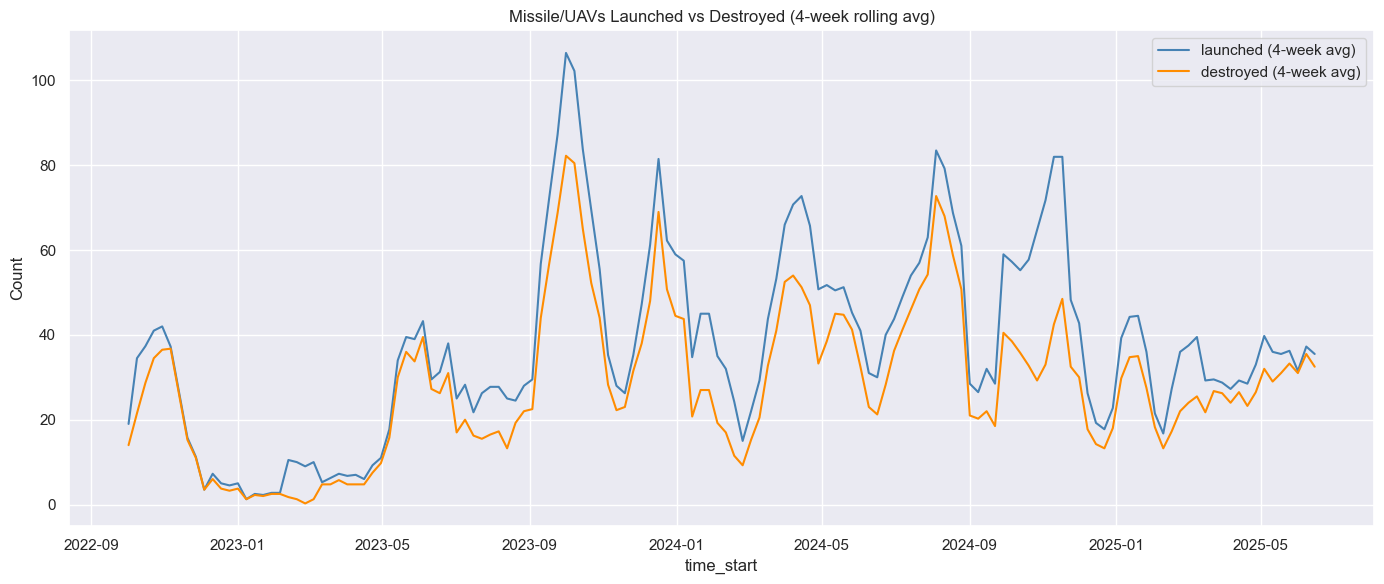

In [20]:
# 4 week rolling average (adjust window for different smoothing)
weekly_smoothed = df_weekly.rolling(window=4, min_periods=1).mean()

# plotting launch vs destroyed over time
plt.figure(figsize=(14, 6))
plt.plot(weekly_smoothed.index, weekly_smoothed['launched'], label='launched (4-week avg)' , color='steelblue')
plt.plot(weekly_smoothed.index, weekly_smoothed['destroyed'], label='destroyed (4-week avg)', color='darkorange')
plt.title("Missile/UAVs Launched vs Destroyed (4-week rolling avg)")
plt.xlabel("time_start")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Creating two separate specially designed datasets for solving the problems

Creating the Linear regression dataset as a seperate csv for solving the how many attacks next month problem

In [21]:

# Create new dataframe for the linear regression problem
linear_regression_df = df[['time_start', 'launched', 'destroyed', 'model']].copy()

# This column contains the launched value from the next row (i.e., the "future" value)
linear_regression_df['launched_next_month'] = linear_regression_df['launched'].shift(-1)


# Save to csv
linear_regression_df.to_csv('model1_dataset.csv', index=False)


Creating the K-means dataset as a seperate csv for solving most attackeck region problem

In [22]:
# Create new dataframe for the K-Means problem
kmeans_df = df[['time_start','target', 'launched', 'destroyed']]

# Save to csv
kmeans_df.to_csv('model2_dataset.csv', index=False)

In [23]:
df.columns

Index(['time_start', 'time_end', 'model', 'launch_place', 'target', 'carrier',
       'launched', 'destroyed', 'not_reach_goal', 'cross_border_belarus',
       'back_russia', 'still_attacking', 'num_hit_location',
       'num_fall_fragment_location', 'affected region', 'destroyed_details',
       'launched_details', 'launch_place_details', 'source',
       'Specific vs Generic', 'target_generic'],
      dtype='object')